In [34]:
# GPU 상태 및 PyTorch 버전 확인
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("⚠️ CUDA is not available!")
    print("가능한 원인:")
    print("1. PyTorch가 CPU 전용으로 설치됨")
    print("2. NVIDIA 드라이버 문제")
    print("3. CUDA 런타임 문제")
    print("\n해결 방법:")
    print("pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

PyTorch Version: 2.7.1+cu118
CUDA Available: True
CUDA Device Count: 1
Current CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA Version: 11.8


# EfficientNet-B0 피부질환 분류 전체 파이프라인
이 노트북은 EfficientNet-B0을 이용한 피부질환 이미지 분류의 데이터 준비, 학습, 검증, 평가, 시각화까지의 전체 과정을 담고 있습니다.

In [35]:
# 1. 라이브러리 임포트 및 환경 설정 (수정)
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models  # models 추가
from torch.utils.data import DataLoader
# from efficientnet_pytorch import EfficientNet  # 주석 처리
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# 2. 데이터 경로 및 하이퍼파라미터 + 결과 저장 폴더 생성
from datetime import datetime
# ★ 조정 가능: 데이터셋 루트 경로 (필요 시 변경)
DATA_DIR = './'  # 데이터셋 폴더 위치  ★
# ★ 조정 가능: 입력 이미지 크기 (모델 요구에 따라 변경)
IMAGE_SIZE = 224  # ★
# ★ 조정 가능: 배치 크기 (메모리/성능 균형)
BATCH_SIZE = 64  # ★ (원래 배치 크기)

# 날짜/시간별 결과 저장 폴더 생성
now_str = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = os.path.join('results', now_str)
os.makedirs(results_dir, exist_ok=True)
print(f'결과 저장 폴더: {results_dir}')

결과 저장 폴더: results\20251029_131046


In [37]:
# 3. 데이터 전처리 및 데이터로더 (최소 설정)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3),
])
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3),
])
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_transform)
# 데이터가 너무 많을 경우 일부만 샘플링해서 사용하려면 아래 주석 해제
# from torch.utils.data import Subset
# train_ds = Subset(train_ds, range(0, min(10, len(train_ds))))
# val_ds = Subset(val_ds, range(0, min(10, len(val_ds))))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
class_names = train_ds.classes if hasattr(train_ds, 'classes') else train_ds.dataset.classes
print(f'클래스 목록: {class_names}')

클래스 목록: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


In [38]:
# 4. 클래스 불균형 보정 (가중치 계산)
labels = [label for _, label in train_ds.samples]
classes = np.arange(len(train_ds.classes))
class_weights = compute_class_weight('balanced', classes=classes, y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print('Class weights:', class_weights)

Class weights: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892], device='cuda:0')


In [39]:
# 5. EfficientNet-B0 모델 생성 및 학습 준비 (수정)
# torchvision 사용 버전 (경고 무시)
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

model = models.efficientnet_b0(pretrained=True)  # 경고는 무시하고 기존 방식 사용 (pretrained=True는 ★)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_ds.classes))
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
# ★ 조정 가능: 옵티마이저 학습률 (lr)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # ★
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# 모델 구조 출력
print("=== 모델 구조 ===")
print(model)

# 각 레이어별 파라미터 확인
print("\n=== 레이어별 파라미터 ===")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

# 모델 상세 정보 추가 분석
print("=== EfficientNet-B0 상세 정보 ===")
print(f"입력 이미지 크기: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"분류 클래스 수: {len(train_ds.classes)}")
print(f"클래스 목록: {class_names}")

# 총 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n=== 파라미터 정보 ===")
print(f"전체 파라미터: {total_params:,}")
print(f"학습 가능한 파라미터: {trainable_params:,}")

# 모델 요약 (torchsummary 설치 필요)
try:
    from torchsummary import summary
    print(f"\n=== 모델 요약 ===")
    summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))
except ImportError:
    print("torchsummary가 설치되지 않음. pip install torchsummary로 설치하세요.")

# 분류기 구조 상세 확인
print(f"\n=== 분류기 구조 ===")
print(f"분류기: {model.classifier}")
print(f"최종 Linear 레이어 입력 차원: {model.classifier[1].in_features}")
print(f"최종 Linear 레이어 출력 차원: {model.classifier[1].out_features}")


=== 모델 구조 ===
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Con

# 5-1. 클래스 레이블 고정/내보내기 + 최종 레이어 정합성 검사
- 학습에 사용된 `class_names`를 JSON/파이썬 모듈로 내보내어 추론 서버(Flask)에서 동일한 레이블 순서를 강제합니다.
- `model.classifier[1].out_features`와 `len(class_names)`가 일치하는지 검사하여 체크포인트/레이블 불일치를 조기 감지합니다.
- 저장 위치:
  - 결과 폴더: `results/<timestamp>/class_labels.json`, `label_index_maps.json`
  - Flask 서버: `../skinseal-pythonAI/models/class_labels_efficientnet.json`, `class_labels_efficientnet.py`

In [40]:
# 5-1. 클래스 레이블 고정/내보내기 + out_features 정합성 검사
import os
import json

# 클래스 수 포함 파일명 구성
class_count = len(class_names)
label_payload = {
    "model_name": "skin_model",
    "num_classes": int(class_count),
    "image_size": int(IMAGE_SIZE),
    "class_names": list(class_names),
}

# 결과 디렉토리에 저장 (클래스 수 포함 파일명)
labels_results_path = os.path.join(results_dir, f"class_labels_{class_count}cls.json")
with open(labels_results_path, "w", encoding="utf-8") as f:
    json.dump(label_payload, f, ensure_ascii=False, indent=2)
print(f"[RESULT] class_labels json saved -> {labels_results_path}")

# 레이블 인덱스 매핑 저장(검증/디버깅용)
index2label = {int(i): name for i, name in enumerate(class_names)}
label2index = {name: int(i) for i, name in enumerate(class_names)}
maps_path = os.path.join(results_dir, f"label_index_maps_{class_count}cls.json")
with open(maps_path, "w", encoding="utf-8") as f:
    json.dump({"index2label": index2label, "label2index": label2index}, f, ensure_ascii=False, indent=2)
print(f"[RESULT] label_index_maps json saved -> {maps_path}")

# 추론 서버(Flask) 쪽에도 내보내기 (클래스 수 포함 파일명)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
ai_models_dir = os.path.join(repo_root, "skinseal-pythonAI", "models")
os.makedirs(ai_models_dir, exist_ok=True)

labels_ai_json = os.path.join(ai_models_dir, f"class_labels_skin_model_{class_count}cls.json")
with open(labels_ai_json, "w", encoding="utf-8") as f:
    json.dump(label_payload, f, ensure_ascii=False, indent=2)
print(f"[RESULT] Exported JSON for Flask AI -> {labels_ai_json}")

# 파이썬 모듈로도 내보내기(직접 import 용)
labels_ai_py = os.path.join(ai_models_dir, f"class_labels_skin_model_{class_count}cls.py")
with open(labels_ai_py, "w", encoding="utf-8") as f:
    f.write("# Auto-generated by efficientnet_pipeline.ipynb\n")
    f.write("MODEL_NAME = 'skin_model'\n")
    f.write(f"NUM_CLASSES = {class_count}\n")
    f.write(f"IMAGE_SIZE = {int(IMAGE_SIZE)}\n")
    f.write("CLASS_LABELS = [\n")
    for name in class_names:
        f.write(f"    {repr(name)},\n")
    f.write("]\n")
    f.write("__all__ = ['MODEL_NAME', 'NUM_CLASSES', 'IMAGE_SIZE', 'CLASS_LABELS']\n")
print(f"[RESULT] Exported Python labels module -> {labels_ai_py}")

# 최종 레이어 출력 차원과 레이블 수 정합성 검사
out_features = getattr(model.classifier[1], 'out_features', None)
match = (out_features == len(class_names))
status = "OK" if match else "MISMATCH"
print(f"[CHECK] model.classifier[1].out_features = {out_features}, len(class_names) = {len(class_names)} -> {status}")
if not match:
    print("\n⚠️ Warning: Final layer output size and label count differ.\n- 모델 헤드(out_features) 또는 레이블 목록을 점검하세요.")

# 복사/검증 편의용 출력
print("[LABELS] " + ", ".join(class_names))

[RESULT] class_labels json saved -> results\20251029_131046\class_labels_22cls.json
[RESULT] label_index_maps json saved -> results\20251029_131046\label_index_maps_22cls.json
[RESULT] Exported JSON for Flask AI -> d:\2ckvmfhwpr\skinseal-pythonAI\models\class_labels_skin_model_22cls.json
[RESULT] Exported Python labels module -> d:\2ckvmfhwpr\skinseal-pythonAI\models\class_labels_skin_model_22cls.py
[CHECK] model.classifier[1].out_features = 22, len(class_names) = 22 -> OK
[LABELS] Acne, Actinic_Keratosis, Benign_tumors, Bullous, Candidiasis, DrugEruption, Eczema, Infestations_Bites, Lichen, Lupus, Moles, Psoriasis, Rosacea, Seborrh_Keratoses, SkinCancer, Sun_Sunlight_Damage, Tinea, Unknown_Normal, Vascular_Tumors, Vasculitis, Vitiligo, Warts


In [41]:
# 5-2. 레거시 파일(efficientnet_b0 …) 자동 정리 유틸
import glob
import shutil

# 안전 모드: True이면 삭제 대신 목록만 출력합니다. 실제 삭제는 False로 변경하세요.
SAFE_MODE = True

# 정리 대상 정의
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
ai_models_dir = os.path.join(repo_root, "skinseal-pythonAI", "models")
legacy_patterns_ai = [
    os.path.join(ai_models_dir, "class_labels_efficientnet*.json"),
    os.path.join(ai_models_dir, "class_labels_efficientnet*.py"),
    os.path.join(ai_models_dir, "best_efficientnet*.pth"),
    os.path.join(ai_models_dir, "latest_efficientnet*.pth"),
]

legacy_patterns_results = [
    os.path.join(results_dir, "best_efficientnet*.pth"),
    os.path.join(results_dir, "latest_efficientnet*.pth"),
    os.path.join(results_dir, "periodic_checkpoints*efficientnet*"),
    os.path.join(results_dir, "class_labels.json"),  # 이전 고정 파일명
    os.path.join(results_dir, "label_index_maps.json"),
]

# 후보 수집
candidates = []
for pat in legacy_patterns_ai + legacy_patterns_results:
    for p in glob.glob(pat):
        candidates.append(p)

# 출력
print("=== 레거시 파일(디렉터리 포함) 후보 목록 ===")
for p in candidates:
    kind = "DIR" if os.path.isdir(p) else "FILE"
    print(f"- [{kind}] {p}")

# 삭제 실행 (SAFE_MODE=False일 때만)
if not SAFE_MODE:
    removed = 0
    for p in candidates:
        try:
            if os.path.isdir(p):
                shutil.rmtree(p, ignore_errors=True)
            else:
                os.remove(p)
            removed += 1
        except Exception as e:
            print(f"삭제 실패: {p} -> {e}")
    print(f"\n🧹 정리 완료: {removed}개 항목 삭제")
else:
    print("\nSAFE_MODE=True: 삭제하지 않고 목록만 출력했습니다.\n실제 삭제하려면 SAFE_MODE=False로 설정 후 다시 실행하세요.")

=== 레거시 파일(디렉터리 포함) 후보 목록 ===
- [FILE] d:\2ckvmfhwpr\skinseal-pythonAI\models\class_labels_efficientnet.json
- [FILE] d:\2ckvmfhwpr\skinseal-pythonAI\models\best_efficientnet.pth

SAFE_MODE=True: 삭제하지 않고 목록만 출력했습니다.
실제 삭제하려면 SAFE_MODE=False로 설정 후 다시 실행하세요.


In [ ]:
# 6. 개선된 학습 루프 (중간 저장, 상세 로깅, 에러 처리 포함)
import time
import copy
from datetime import datetime

# ★ 조정 가능: 전체 훈련 에폭 수
EPOCHS = 35  # ★ (원래 에폭 수)
best_val_acc = 0
# ★ 조정 가능: EarlyStopping patience (에폭 수)
patience, counter = 5, 0  # patience=5  ★

# 다양한 체크포인트 경로 설정 (클래스 수를 파일명에 포함)
class_count = len(class_names) if 'class_names' in globals() else (getattr(model.classifier[1], 'out_features', None) or 0)
model_name_base = f"skin_model_{class_count}cls"

checkpoint_path = os.path.join(results_dir, f'best_{model_name_base}.pth')
latest_checkpoint = os.path.join(results_dir, f'latest_{model_name_base}.pth')
periodic_checkpoint_dir = os.path.join(results_dir, f'periodic_checkpoints_{model_name_base}')
os.makedirs(periodic_checkpoint_dir, exist_ok=True)

log_path = os.path.join(results_dir, 'train_log.txt')
metrics_log_path = os.path.join(results_dir, 'metrics_log.csv')

# 메트릭 로깅을 위한 리스트
train_losses, val_losses = [], []
train_accs, val_accs = [], []
log_lines = []

# 메트릭 CSV 헤더 생성
with open(metrics_log_path, 'w', encoding='utf-8') as f:
    f.write('epoch,train_loss,train_acc,val_loss,val_acc,learning_rate,timestamp\n')

print("🚀 학습 시작!")
print(f"📁 결과 저장 위치: {results_dir}")
print(f"🎯 목표 에폭: {EPOCHS}")
print(f"⏰ Early stopping patience: {patience}")
print(f"💾 체크포인트 저장 간격: 매 에폭")
print(f"🧾 모델 파일 접두사: {model_name_base}")
print("-" * 50)

start_time = time.time()

try:
    for epoch in range(1, EPOCHS+1):
        epoch_start_time = time.time()
        
        # =========================
        # 훈련 단계
        # =========================
        model.train()
        train_loss = train_correct = train_total = 0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            train_correct += preds.eq(labels).sum().item()
            train_total += labels.size(0)
            
            # 배치마다 진행 상황 출력 (매 10번째 배치)
            if batch_idx % 10 == 0 and batch_idx > 0:
                current_loss = train_loss / train_total
                current_acc = train_correct / train_total
                print(f"  Epoch {epoch}/{EPOCHS} - Batch {batch_idx}/{len(train_loader)} - Loss: {current_loss:.4f}, Acc: {current_acc:.4f}")
        
        train_loss = train_loss / train_total if train_total > 0 else 0
        train_acc = train_correct / train_total if train_total > 0 else 0
        
        # =========================
        # 검증 단계
        # =========================
        model.eval()
        val_loss = val_correct = val_total = 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * imgs.size(0)
                _, preds = outputs.max(1)
                val_correct += preds.eq(labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / val_total if val_total > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0
        
        # 스케줄러 업데이트
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        
        # 메트릭 저장
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # 에폭 시간 계산
        epoch_time = time.time() - epoch_start_time
        
        # =========================
        # 로깅 및 출력
        # =========================
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        log_line = f'Epoch {epoch}/{EPOCHS} ({epoch_time:.1f}s) - Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | LR={current_lr:.2e}'
        print(log_line)
        log_lines.append(log_line)
        
        # CSV 메트릭 로그 저장
        with open(metrics_log_path, 'a', encoding='utf-8') as f:
            f.write(f'{epoch},{train_loss:.6f},{train_acc:.6f},{val_loss:.6f},{val_acc:.6f},{current_lr:.2e},{timestamp}\n')
        
        # =========================
        # 모델 저장 (중간 저장 포함)
        # =========================
        
        # 1. 매 에폭마다 최신 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'best_val_acc': best_val_acc,
        }, latest_checkpoint)
        
        # 2. 베스트 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
            # 베스트 모델 저장 (전체 정보 포함)
            torch.save({
                'epoch': epoch,
                'model_state_dict': copy.deepcopy(model.state_dict()),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'best_val_acc': best_val_acc,
                'class_names': class_names,
                'model_config': {
                    'model_name': model_name_base,
                    'num_classes': len(class_names),
                    'image_size': IMAGE_SIZE,
                    'batch_size': BATCH_SIZE,
                }
            }, checkpoint_path)
            
            print(f'📌 새로운 베스트 모델 저장! Val Acc: {val_acc:.4f}')
            log_lines.append(f'Best model saved at epoch {epoch} with val_acc: {val_acc:.4f}')
            counter = 0
        else:
            counter += 1
        
        # 3. 주기적 체크포인트 저장 (매 5 에폭마다)
        if epoch % 5 == 0:
            periodic_checkpoint = os.path.join(periodic_checkpoint_dir, f'{model_name_base}_epoch_{epoch:03d}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
            }, periodic_checkpoint)
            print(f'💾 주기적 체크포인트 저장: epoch_{epoch:03d}')
        
        # =========================
        # Early Stopping 확인
        # =========================
        if counter >= patience:
            print(f'⏹️ Early stopping triggered at epoch {epoch}')
            print(f'🏆 Best validation accuracy: {best_val_acc:.4f}')
            log_lines.append(f'Early stopping at epoch {epoch}')
            break
        
        # 남은 patience 표시
        if counter > 0:
            print(f"⚠️ Early stopping counter: {counter}/{patience}")

except KeyboardInterrupt:
    print("\n🛑 학습이 사용자에 의해 중단되었습니다.")
    log_lines.append("Training interrupted by user")
except Exception as e:
    print(f"\n❌ 학습 중 오류 발생: {e}")
    log_lines.append(f"Training error: {str(e)}")
finally:
    # 최종 로그 저장
    total_time = time.time() - start_time
    final_log = f"\n학습 완료!\n총 소요 시간: {total_time/60:.1f}분\n최고 검증 정확도: {best_val_acc:.4f}"
    print(final_log)
    log_lines.append(final_log)
    
    # 텍스트 로그 파일 저장
    with open(log_path, 'w', encoding='utf-8') as f:
        for line in log_lines:
            f.write(line + '\n')

# 베스트 모델 로드
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'✅ 베스트 모델 로드 완료! (에폭 {checkpoint["epoch"]}, Val Acc: {checkpoint["val_acc"]:.4f})')
else:
    print('⚠️ 베스트 모델 파일을 찾을 수 없습니다. 현재 모델 상태를 유지합니다.')

🚀 학습 시작!
📁 결과 저장 위치: results\20251029_131046
🎯 목표 에폭: 40
⏰ Early stopping patience: 5
💾 체크포인트 저장 간격: 매 에폭
🧾 모델 파일 접두사: skin_model_22cls
--------------------------------------------------
  Epoch 1/40 - Batch 10/435 - Loss: 3.0789, Acc: 0.0682
  Epoch 1/40 - Batch 10/435 - Loss: 3.0789, Acc: 0.0682
  Epoch 1/40 - Batch 20/435 - Loss: 3.0665, Acc: 0.0833
  Epoch 1/40 - Batch 20/435 - Loss: 3.0665, Acc: 0.0833
  Epoch 1/40 - Batch 30/435 - Loss: 3.0473, Acc: 0.0948
  Epoch 1/40 - Batch 30/435 - Loss: 3.0473, Acc: 0.0948
  Epoch 1/40 - Batch 40/435 - Loss: 3.0296, Acc: 0.1059
  Epoch 1/40 - Batch 40/435 - Loss: 3.0296, Acc: 0.1059
  Epoch 1/40 - Batch 50/435 - Loss: 3.0042, Acc: 0.1176
  Epoch 1/40 - Batch 50/435 - Loss: 3.0042, Acc: 0.1176
  Epoch 1/40 - Batch 60/435 - Loss: 2.9929, Acc: 0.1281
  Epoch 1/40 - Batch 60/435 - Loss: 2.9929, Acc: 0.1281
  Epoch 1/40 - Batch 70/435 - Loss: 2.9776, Acc: 0.1364
  Epoch 1/40 - Batch 70/435 - Loss: 2.9776, Acc: 0.1364
  Epoch 1/40 - Batch 80/435 -

In [43]:
# 7. 평가 및 리포트 생성 (오류 수정용 셀)
# 이 셀은 학습이 완료된 베스트 모델을 사용하여 검증 데이터셋 전체에 대한 예측을 수행하고,
# 'all_labels'와 'all_preds' 변수를 생성하여 이후의 혼동 행렬 시각화 및 리포트 생성에 사용합니다.

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json

# 이전에 학습된 모델이 'model' 변수에 로드되어 있다고 가정합니다.
# (학습 루프 마지막에 베스트 모델이 로드됩니다)
model.eval()
all_labels = []
all_preds = []
all_probs = []

print("🔍 검증 데이터셋 전체에 대한 평가를 시작합니다...")

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        
        outputs = model(imgs)
        
        # 확률 및 예측 클래스 계산
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

print("✅ 평가 완료. 'all_labels' 및 'all_preds' 생성됨.")

# --- 상세 리포트 및 결과 저장 ---

# 1. Classification Report (사전/재현율/F1)
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_text = classification_report(all_labels, all_preds, target_names=class_names)

# 2. Confusion Matrix (데이터)
cm_data = confusion_matrix(all_labels, all_preds).tolist()

# 3. 전체 정확도
accuracy = accuracy_score(all_labels, all_preds)
report_dict['accuracy'] = accuracy

# 4. JSON으로 결과 저장
eval_results_path = os.path.join(results_dir, 'evaluation_results.json')
with open(eval_results_path, 'w', encoding='utf-8') as f:
    json.dump({
        'classification_report': report_dict,
        'confusion_matrix': cm_data,
        'accuracy': accuracy
    }, f, ensure_ascii=False, indent=2)

# 5. 텍스트 리포트 저장
report_text_path = os.path.join(results_dir, 'classification_report.txt')
with open(report_text_path, 'w', encoding='utf-8') as f:
    f.write(f"Classification Report (Accuracy: {accuracy:.4f})\n")
    f.write("="*50 + "\n")
    f.write(report_text)

# 6. 예측 결과 상세 저장 (CSV)
predictions_df = pd.DataFrame({
    'true_label_idx': all_labels,
    'predicted_label_idx': all_preds,
    'true_label_name': [class_names[i] for i in all_labels],
    'predicted_label_name': [class_names[i] for i in all_preds]
})
# 각 클래스별 예측 확률 추가
prob_df = pd.DataFrame(all_probs, columns=[f'prob_{name}' for name in class_names])
predictions_detailed_df = pd.concat([predictions_df, prob_df], axis=1)
predictions_path = os.path.join(results_dir, 'predictions_detailed.csv')
predictions_detailed_df.to_csv(predictions_path, index=False, encoding='utf-8-sig')


# 7. 오분류 분석
misclassified_df = predictions_detailed_df[predictions_detailed_df['true_label_idx'] != predictions_detailed_df['predicted_label_idx']]
misclassified_path = os.path.join(results_dir, 'misclassified_analysis.csv')
misclassified_df.to_csv(misclassified_path, index=False, encoding='utf-8-sig')


print(f"💾 평가 결과 저장 완료:")
print(f"  - JSON 리포트: {eval_results_path}")
print(f"  - 텍스트 리포트: {report_text_path}")
print(f"  - 상세 예측 결과: {predictions_path}")
print(f"  - 오분류 분석: {misclassified_path}")
print("\n--- Classification Report ---")
print(report_text)


🔍 검증 데이터셋 전체에 대한 평가를 시작합니다...
✅ 평가 완료. 'all_labels' 및 'all_preds' 생성됨.
💾 평가 결과 저장 완료:
  - JSON 리포트: results\20251029_131046\evaluation_results.json
  - 텍스트 리포트: results\20251029_131046\classification_report.txt
  - 상세 예측 결과: results\20251029_131046\predictions_detailed.csv
  - 오분류 분석: results\20251029_131046\misclassified_analysis.csv

--- Classification Report ---
                     precision    recall  f1-score   support

               Acne       0.87      0.89      0.88        65
  Actinic_Keratosis       0.76      0.81      0.78        83
      Benign_tumors       0.72      0.75      0.74       121
            Bullous       0.68      0.76      0.72        55
        Candidiasis       0.62      0.74      0.68        27
       DrugEruption       0.71      0.72      0.72        61
             Eczema       0.77      0.77      0.77       112
 Infestations_Bites       0.71      0.58      0.64        60
             Lichen       0.67      0.67      0.67        61
              Lupus  

In [44]:
# 모델 저장/로드 유틸리티 함수들
import json
import pickle

def save_complete_model(model, save_dir, model_name, epoch, metrics, config):
    """
    완전한 모델 정보를 저장하는 함수
    """
    # 1. 모델 상태 저장
    model_path = os.path.join(save_dir, f'{model_name}_epoch_{epoch:03d}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'metrics': metrics,
        'config': config,
        'timestamp': datetime.now().isoformat(),
    }, model_path)
    
    # 2. 설정 정보 JSON으로 저장
    config_path = os.path.join(save_dir, f'{model_name}_config.json')
    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)
    
    # 3. 메트릭 정보 저장
    metrics_path = os.path.join(save_dir, f'{model_name}_metrics.json')
    with open(metrics_path, 'w', encoding='utf-8') as f:
        json.dump(metrics, f, indent=2, ensure_ascii=False)
    
    return model_path

def load_complete_model(model, checkpoint_path):
    """
    완전한 모델 정보를 로드하는 함수
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return {
        'epoch': checkpoint['epoch'],
        'metrics': checkpoint['metrics'],
        'config': checkpoint['config'],
        'timestamp': checkpoint.get('timestamp', 'Unknown'),
    }

def create_model_summary(model, save_path):
    """
    모델 요약 정보를 생성하고 저장
    """
    summary_info = {
        'model_type': type(model).__name__,
        'total_params': sum(p.numel() for p in model.parameters()),
        'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'model_size_mb': sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024),
        'layers': [],
    }
    
    # 레이어 정보 수집
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # leaf module만
            summary_info['layers'].append({
                'name': name,
                'type': type(module).__name__,
                'parameters': sum(p.numel() for p in module.parameters()),
            })
    
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(summary_info, f, indent=2, ensure_ascii=False)
    
    return summary_info

# 모델 요약 정보 저장
summary_path = os.path.join(results_dir, 'model_summary.json')
model_summary = create_model_summary(model, summary_path)

print("=== 모델 요약 ===")
print(f"총 파라미터: {model_summary['total_params']:,}")
print(f"학습 가능한 파라미터: {model_summary['trainable_params']:,}")
print(f"모델 크기: {model_summary['model_size_mb']:.2f} MB")
print(f"요약 정보 저장: {summary_path}")

# 자동 백업 설정
def setup_auto_backup(results_dir, max_backups=5):
    """
    이전 결과들을 자동으로 백업하는 함수
    """
    backup_dir = os.path.join(results_dir, 'backups')
    os.makedirs(backup_dir, exist_ok=True)
    
    # 기존 백업 파일들 확인
    backup_files = [f for f in os.listdir(backup_dir) if f.startswith('backup_')]
    if len(backup_files) >= max_backups:
        # 가장 오래된 백업 삭제
        backup_files.sort()
        oldest_backup = os.path.join(backup_dir, backup_files[0])
        if os.path.isdir(oldest_backup):
            import shutil
            shutil.rmtree(oldest_backup)
    
    return backup_dir

backup_dir = setup_auto_backup(results_dir)
print(f"백업 디렉토리 설정: {backup_dir}")

=== 모델 요약 ===
총 파라미터: 4,035,730
학습 가능한 파라미터: 4,035,730
모델 크기: 15.40 MB
요약 정보 저장: results\20251029_131046\model_summary.json
백업 디렉토리 설정: results\20251029_131046\backups


In [45]:
# 실시간 학습 곡선 시각화 및 모니터링
import matplotlib.pyplot as plt
import pandas as pd

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, save_path=None):
    """
    학습 곡선을 시각화하는 함수
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss 곡선
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy 곡선
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"학습 곡선 저장: {save_path}")
    
    plt.show()

def monitor_training_progress(metrics_log_path):
    """
    학습 진행상황을 모니터링하는 함수
    """
    if os.path.exists(metrics_log_path):
        df = pd.read_csv(metrics_log_path)
        
        print("=== 학습 진행 상황 ===")
        if len(df) > 0:
            latest = df.iloc[-1]
            print(f"현재 에폭: {int(latest['epoch'])}")
            print(f"최신 Train Loss: {latest['train_loss']:.4f}")
            print(f"최신 Train Acc: {latest['train_acc']:.4f}")
            print(f"최신 Val Loss: {latest['val_loss']:.4f}")
            print(f"최신 Val Acc: {latest['val_acc']:.4f}")
            print(f"현재 Learning Rate: {latest['learning_rate']:.2e}")
            
            # 최고 성능 확인
            best_epoch = df.loc[df['val_acc'].idxmax()]
            print(f"\n=== 최고 성능 ===")
            print(f"최고 Val Acc: {best_epoch['val_acc']:.4f} (에폭 {int(best_epoch['epoch'])})")
            
            return df
    
    return None

def save_training_summary(results_dir, train_losses, val_losses, train_accs, val_accs, best_val_acc, total_epochs):
    """
    학습 완료 후 전체 요약을 저장하는 함수
    """
    summary = {
        'training_completed': True,
        'total_epochs': total_epochs,
        'best_validation_accuracy': float(best_val_acc),
        'final_train_loss': float(train_losses[-1]) if train_losses else 0,
        'final_val_loss': float(val_losses[-1]) if val_losses else 0,
        'final_train_acc': float(train_accs[-1]) if train_accs else 0,
        'final_val_acc': float(val_accs[-1]) if val_accs else 0,
        'training_history': {
            'train_losses': [float(x) for x in train_losses],
            'val_losses': [float(x) for x in val_losses],
            'train_accs': [float(x) for x in train_accs],
            'val_accs': [float(x) for x in val_accs],
        },
        'timestamp': datetime.now().isoformat(),
    }
    
    summary_path = os.path.join(results_dir, 'training_summary.json')
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"학습 요약 저장: {summary_path}")
    return summary_path

print("📊 학습 모니터링 함수들이 준비되었습니다.")
print("- plot_training_curves(): 학습 곡선 시각화")
print("- monitor_training_progress(): 실시간 진행상황 확인")
print("- save_training_summary(): 학습 완료 후 요약 저장")

📊 학습 모니터링 함수들이 준비되었습니다.
- plot_training_curves(): 학습 곡선 시각화
- monitor_training_progress(): 실시간 진행상황 확인
- save_training_summary(): 학습 완료 후 요약 저장


In [46]:
# 7. 개선된 평가 및 리포트 + 완전한 결과 저장
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import numpy as np
import json
import pandas as pd

학습 곡선 저장: results\20251029_131046\training_curves.png


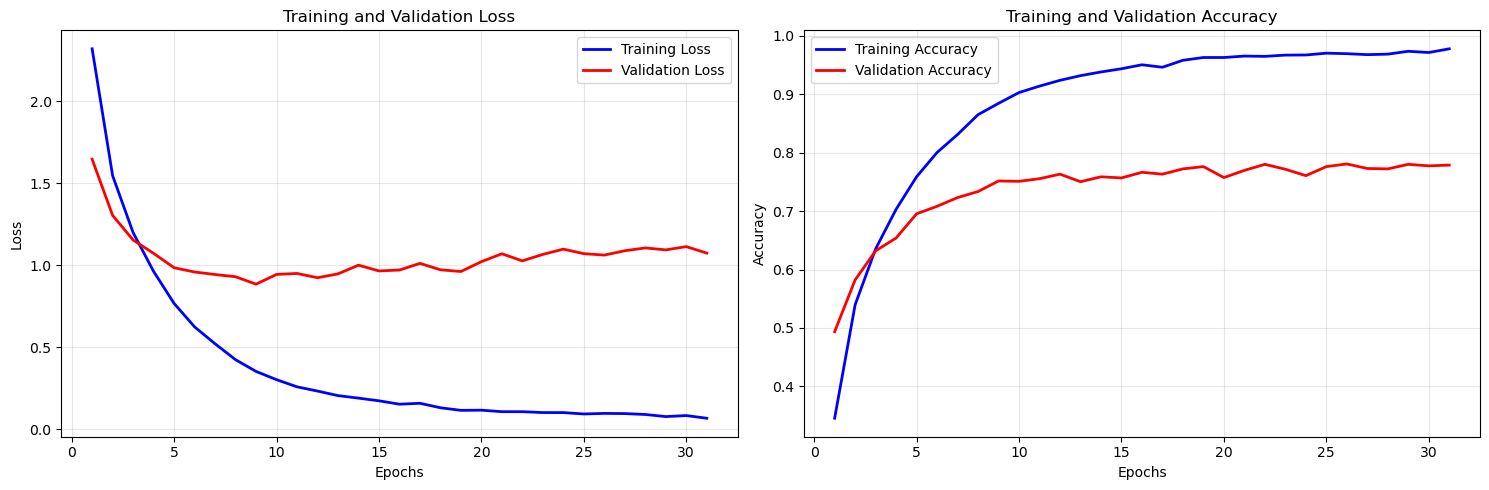

학습 요약 저장: results\20251029_131046\training_summary.json
=== 학습 진행 상황 ===
현재 에폭: 31
최신 Train Loss: 0.0657
최신 Train Acc: 0.9779
최신 Val Loss: 1.0736
최신 Val Acc: 0.7788
현재 Learning Rate: 5.00e-05

=== 최고 성능 ===
최고 Val Acc: 0.7807 (에폭 26)

📊 모든 결과가 'results\20251029_131046' 폴더에 저장되었습니다!

저장된 파일들:
📈 training_curves.png - 학습 곡선 그래프
📋 training_summary.json - 전체 학습 요약
📊 metrics_log.csv - 에폭별 상세 메트릭
🏆 best_skin_model_22cls.pth - 최고 성능 모델
💾 latest_skin_model_22cls.pth - 최신 모델
📁 periodic_checkpoints_skin_model_22cls/ - 주기적 체크포인트들
📄 train_log.txt - 학습 로그
🔍 evaluation_results.json - 상세 평가 결과
📝 classification_report.txt - 분류 리포트
🎯 predictions_detailed.csv - 예측 상세 결과
⚠️ misclassified_analysis.csv - 오분류 분석


In [47]:
# 학습 곡선 시각화 및 최종 요약 저장
if len(train_losses) > 0:  # 학습이 실제로 실행된 경우에만
    # 학습 곡선 플롯
    curves_path = os.path.join(results_dir, 'training_curves.png')
    plot_training_curves(train_losses, val_losses, train_accs, val_accs, save_path=curves_path)
    
    # 최종 학습 요약 저장
    summary_path = save_training_summary(results_dir, train_losses, val_losses, train_accs, val_accs, best_val_acc, len(train_losses))
    
    # 진행상황 모니터링 (CSV가 존재하는 경우)
    metrics_log_path = os.path.join(results_dir, 'metrics_log.csv')
    df_metrics = monitor_training_progress(metrics_log_path)
    
    # 동적 파일명 안내 (클래스 수 포함 접두사)
    try:
        class_count = len(class_names)
        model_name_base = f"skin_model_{class_count}cls"
    except Exception:
        model_name_base = "skin_model"
    
    print(f"\n📊 모든 결과가 '{results_dir}' 폴더에 저장되었습니다!")
    print("\n저장된 파일들:")
    print("📈 training_curves.png - 학습 곡선 그래프")
    print("📋 training_summary.json - 전체 학습 요약")
    print("📊 metrics_log.csv - 에폭별 상세 메트릭")
    print(f"🏆 best_{model_name_base}.pth - 최고 성능 모델")
    print(f"💾 latest_{model_name_base}.pth - 최신 모델")
    print(f"📁 periodic_checkpoints_{model_name_base}/ - 주기적 체크포인트들")
    print("📄 train_log.txt - 학습 로그")
    print("🔍 evaluation_results.json - 상세 평가 결과")
    print("📝 classification_report.txt - 분류 리포트")
    print("🎯 predictions_detailed.csv - 예측 상세 결과")
    print("⚠️ misclassified_analysis.csv - 오분류 분석")
else:
    print("⚠️ 학습이 아직 실행되지 않았습니다. 먼저 학습을 실행해주세요.")

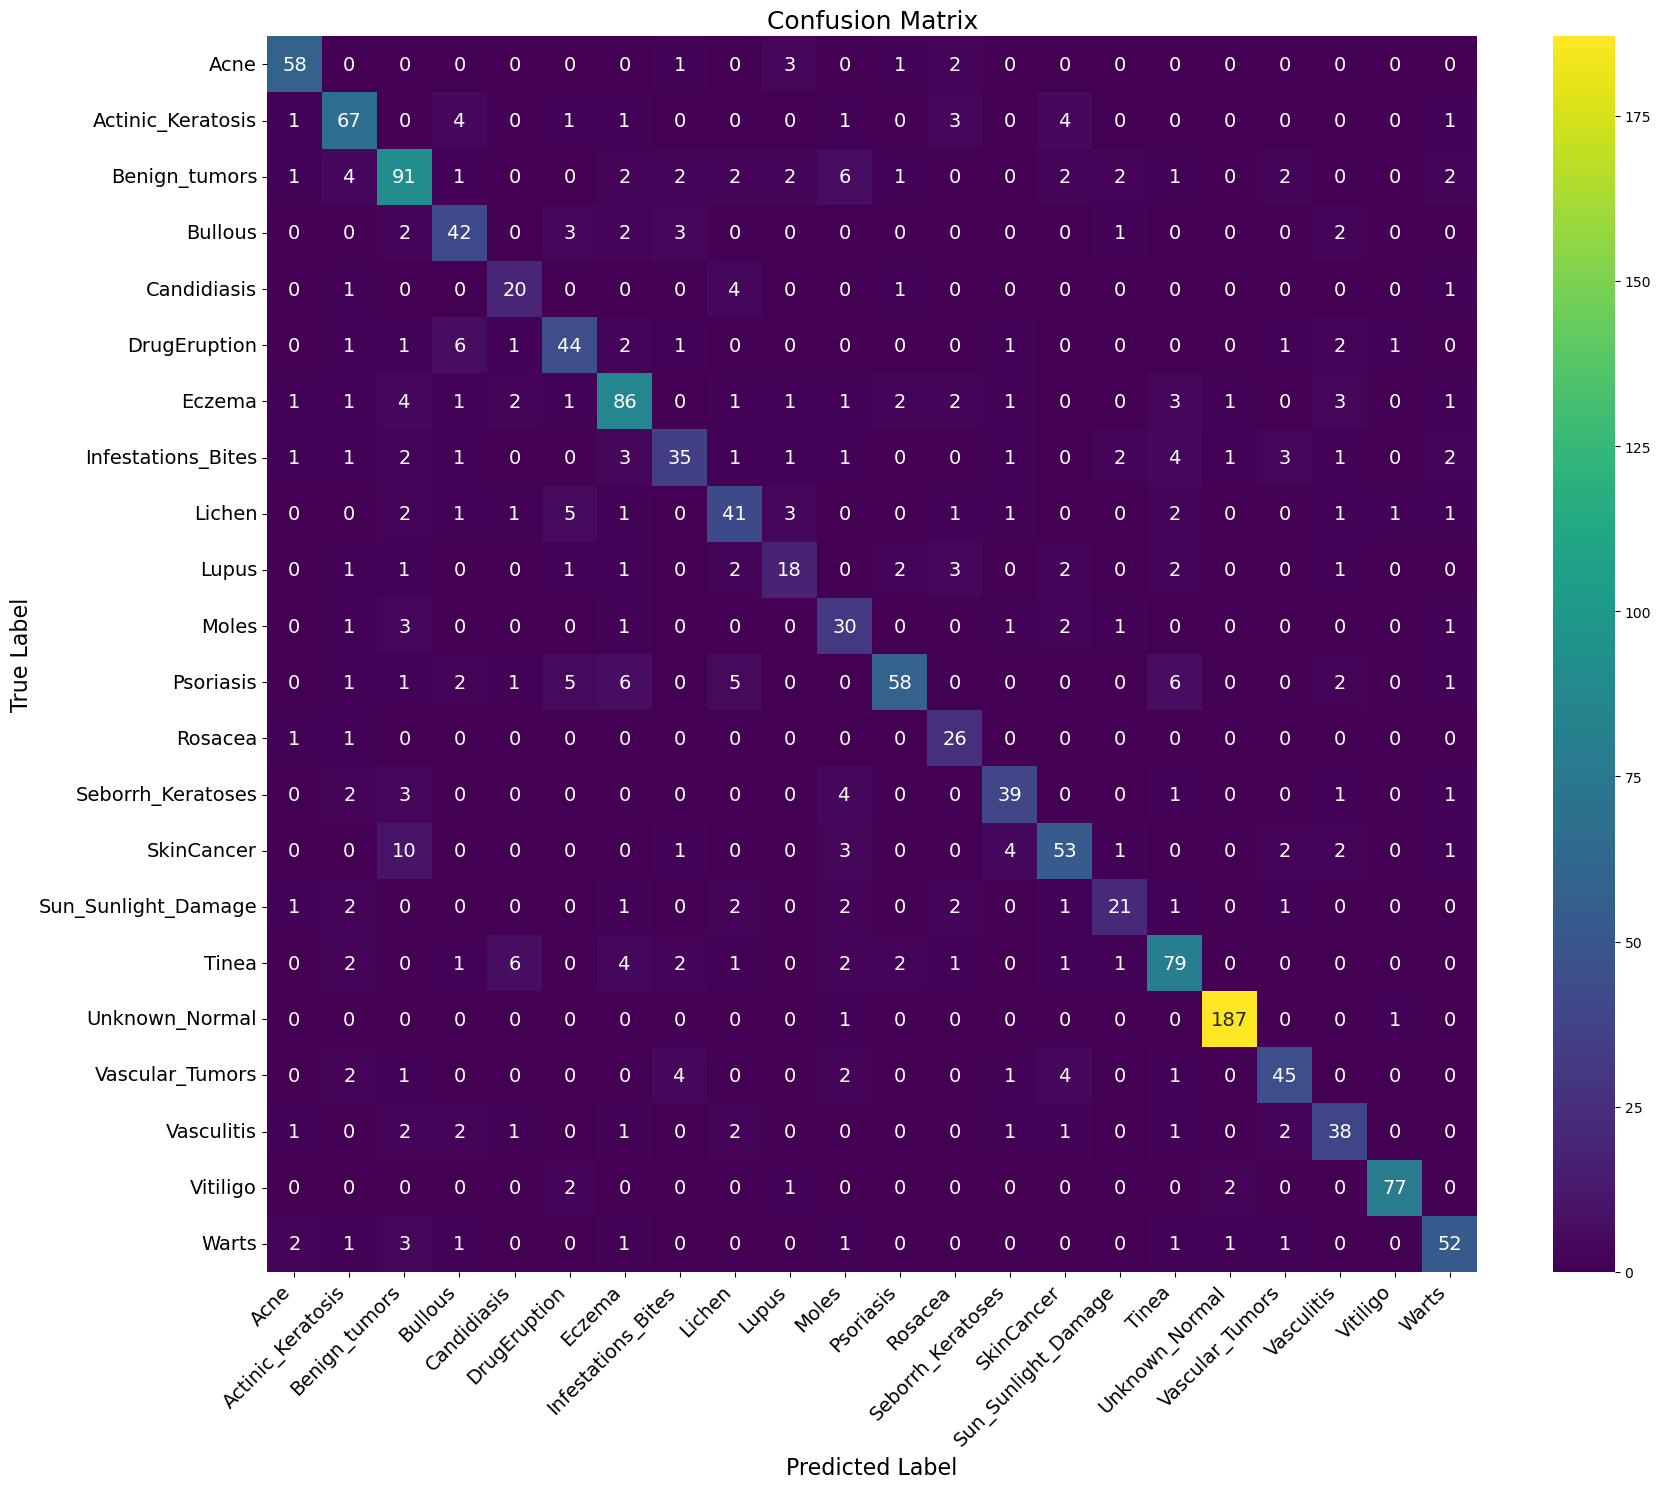

In [48]:
# 8. 혼동행렬 시각화 + 이미지 저장
def plot_confusion_matrix_large(y_true, y_pred, class_names, figsize=(15, 12), fontsize=12, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names, annot_kws={'size': fontsize})
    plt.xlabel('Predicted Label', fontsize=fontsize + 2)
    plt.ylabel('True Label', fontsize=fontsize + 2)
    plt.title('Confusion Matrix', fontsize=fontsize + 4)
    plt.xticks(rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

cm_path = os.path.join(results_dir, 'confusion_matrix.png')
plot_confusion_matrix_large(all_labels, all_preds, class_names, figsize=(18, 15), fontsize=14, save_path=cm_path)

In [49]:
# 클래스 개수 및 목록 확인
print(f"클래스 수: {len(train_ds.classes)}")
print("클래스 목록:")
for i, name in enumerate(train_ds.classes):
    print(f"{i:2d}. {name}")


클래스 수: 22
클래스 목록:
 0. Acne
 1. Actinic_Keratosis
 2. Benign_tumors
 3. Bullous
 4. Candidiasis
 5. DrugEruption
 6. Eczema
 7. Infestations_Bites
 8. Lichen
 9. Lupus
10. Moles
11. Psoriasis
12. Rosacea
13. Seborrh_Keratoses
14. SkinCancer
15. Sun_Sunlight_Damage
16. Tinea
17. Unknown_Normal
18. Vascular_Tumors
19. Vasculitis
20. Vitiligo
21. Warts
